# Влияние learning rate и масштаба признаков на сходимость

In [1]:
import tensorflow.compat.v1 as tf

2022-07-25 22:24:45.670437: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
print("TF", tf.__version__)
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML, display_html
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html, HTML
import contextlib
import time
import io
import urllib
import base64
import keras
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term
TF 2.8.0


In [2]:
def clear_and_display_figure(fig, sleep=0.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)

# запись анимации для Колаба
class SimpleMovieWriter(object):
    """
    Usage example:
        anim = animation.FuncAnimation(...)
        anim.save(None, writer=SimpleMovieWriter(sleep=0.01))
    """
    def __init__(self, sleep=0.1):
        self.sleep = sleep

    def setup(self, fig):
        self.fig = fig

    def grab_frame(self, **kwargs):
        clear_and_display_figure(self.fig, self.sleep)

    @contextlib.contextmanager
    def saving(self, fig, *args, **kwargs):
        self.setup(fig)
        try:
            yield self
        finally:
            pass
          
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [3]:
# скидываем сессию
s = reset_tf_session()

Лосс на одном объекте: $l = (x_1 w_1 + x_2 w_2 - y)^2$

[Каноническое уравнение эллипса](https://ru.wikipedia.org/wiki/Эллипс): $\frac{x_1^2}{a^2} + \frac{x_2^2}{b^2} = 1$, поэтому [линии уровня](https://foxford.ru/wiki/matematika/metod-liniy-urovnya) лосса так выглядят.

Если мы будем увеличивать масштаб $x_1$, это будет сплющивать ось $w_1$ на графике линий уровня.

Разные по масштабу градиенты если разный масштаб признаков:

$ \frac{dl}{dw_1} = 2 (x_1 w_1 + x_2 w_2 - y) x_1$

$ \frac{dl}{dw_2} = 2 (x_1 w_1 + x_2 w_2 - y) x_2$

<a list of 20 text.Text objects>

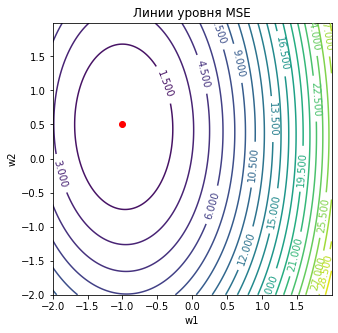

In [4]:
# генерируем простой датасет
np.random.seed(42)
N = 100
x = np.random.randn(N, 2)
w = np.array([[-1, 0.5]]).T
x[:, 0] *= 2  # признак x1 в x_scale раз больше (создает долины в лоссе)
y = x @ w + np.random.randn(N, 1) * 0.2
    
# рисуем линии уровня лосса в пространстве весов
fig, ax = plt.subplots(figsize=(5, 5))
W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
contour = ax.contour(W1, W2, Z, 20)
ax.scatter(*w, c='red')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title(u"Линии уровня MSE")
ax.clabel(contour, inline=1, fontsize=10)

In [5]:
# визуализация шагов
def plot_gd(x_scale, lr, steps, optimizer='sgd'):
    # генерируем простой датасет
    np.random.seed(42)
    N = 100
    x = np.random.randn(N, 2)
    w = np.array([[-1, 0.5]]).T
    x[:, 0] *= x_scale  # признак x1 в x_scale раз больше (создает долины в лоссе)
    y = x @ w + np.random.randn(N, 1) * 0.2
    
    # оптимизация в TF
    w_guess = tf.Variable([1.5, 1.5], dtype='float32')  
    loss = tf.reduce_mean((tf.constant(x, tf.float32) * w_guess - tf.constant(y, tf.float32)) ** 2)
    if optimizer == 'sgd':
        step = tf.train.GradientDescentOptimizer(lr).minimize(loss, var_list=w_guess)
    elif optimizer == 'adam':
        step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=w_guess)

    # рисуем линии уровня лосса в пространстве весов
    fig, ax = plt.subplots(figsize=(5, 5))
    W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
    Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
    contour = ax.contour(W1, W2, Z, 20)
    ax.scatter(*w, c='red')
    ax.clabel(contour, inline=1, fontsize=10)
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.title(u"Линии уровня MSE")
    line, = ax.plot([], [], lw=2)
    
    s.run(tf.global_variables_initializer())

    # стартуем анимацию с пустой траекторией
    def init():
        line.set_data([], [])
        return (line,)

    trajectory = [s.run(w_guess)]

    # один шаг анимации (шаг бекпроп)
    def animate(i):
        s.run(step)
        trajectory.append(s.run(w_guess))
        line.set_data(*zip(*trajectory))
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=steps, interval=20, blit=True)

    anim.save(None, writer=SimpleMovieWriter(0.0001))

# Простой SGD

У наивного SGD есть проблемы, он плохо сходится когда производные по разным весам слишком разные по масштабу!

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeJ/tofEv9pXwVL8LvAv7LGp%2BBtP8Q%2BP/AIlHQr3U/iBod5qNlZ2Eeh6vqc0iQWl1au82dORFzKFw7Z6hlaV3YD2yivGf%2BEH/AOChff8Aah%2BDP/hh9W/%2BaiqLad%2B3KviIeEG/bC%2BBY1ZrX7Suln4Jan9oMOdvm%2BX/AMJVu2Z43YxnvQk3sB7pRXh2uaL%2B3d4Y0mfX/Ev7XXwO06xtU33N7ffBDVIYYl/vM7%2BKQFHuTXg%2Bvf8ABQH4uLq8/hf4TftffDb4pazA%2B2TSvhV%2BzF4g10g%2B9xB4m%2BzJ9WlHr05rajhsRiL%2Bzg3bstF6vZfNoTaW5900V8K6P8WP%2BC9Xj%2B%2BRvAfwd%2BDOh6XKcxaj8S/CV3pku3sWtrDxDfSL9GINet%2BAfB//AAV2vAs3xR/aI/Zw044O620D4M6/e846CSbxFB377PwFOrhqlFe84%2Bikm/wv%2BYJpn0fRXjP/AAg//BQv/o6D4M/%2BGH1b/wCaij/hB/8AgoX/ANHQfBn/AMMPq3/zUVzjPZqwfidJ8TYvh/qz/Bmy0K48U/Y2GhR%2BJ7qaHT/tB4Vp2gR5Ng5YhFy2NuVzuHm//CD/APBQv/o6D4M/%2BGH1b/5qKP8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUAcB8Lf2APF3wftf2YPD%2Bi%2BOtO1a2%2BCdxrNz4w1S9SS3n1i61DSLy3muLeFVdVL3l20pR3GxGIDORg%2BRfsG/8ABJb46/s1XXwH%2BIHxi8f%2BEtb8Y/D28vLXxdeaTc3Rgi0SHQbzStJ07TjLArSJG9zJdy%2BaIv319dsuRsWvpXUvAv8AwUcaxkGkftSfBJbnb%2B5Nz8BNYZM%2B4XxSD%2BXT36V5R48j/wCC9nhffd%2BCPEH7KviuBPuwDwh4h025f6LJqskf5yCtaVJ1XZNL1aX5ibscj%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKjYP7YH/BT/wAAfu/2k/h/YeDkTm41fQ/2c9Q8TaZCnd2m0zxZJKq%2B7Qj3weK9B%2BCv7Sfxi/aIm%2BwfBr/gox%2Bztrd%2BCRJo8fwW1WHUIyOoe0m8UJOmOfvIOh9K1qYHF04c7g3HurSX3xbX32BSTOE/YG/4JYfGr9l/XvgV8SPi3478La54t8EeCtU0T4halpdxcmOVP7O0rTdItNPEkClra3tdN%2BfzPKLTTTTBN07gTf8ABWP4a2vxu%2BPHwb%2BBXwu%2BImn2fjb4hT6h4O%2BIHh%2BGfde3Pw2vkW61y4ZEO6JAdLht4rhwEEt20anfLtb6C/4Qf/goX/0dB8Gf/DD6t/8ANRSr4H/4KEhgX/af%2BDRGeQPgRqwOP/CorlGfLnxY%2BEP7Svxb/bX/AGrPgf8As52Xw9g0rxx8HPBvhfxBfeLrq6t5NCt7i212AXlrDbW8q3xSKaYfZJGtlLBD5yjcp6rx3/wTg/aCj0r4lfs4fDDxL4Om%2BFfxg8R6DqviTxJ4g1O7XxFoK2WnaTpt1BbW8ds8N8ZoNHgaKaS4tzbyTuSkyoi16bdT/wDBTnw%2BNUu/GvxY%2BCtrZ2sN3dWF1ovwj1i/EkEKBwJhJr9v5MrgnaAXXKsNw4Lea3f7V/7dFta%2BGTD8Y/g3fXeteD7XW9WstH%2BEeqXR02W82LYWSMfESLcy3D%2Bftz5QWO1mkbhQG6o4OtUvyWfo/K/9bdDN1YLfQ5/w/wD8EzP2ltO/bauPjk83he20EfH648f2muv8WNfv2FhLZ/ZnsR4Xms10mG7dDIn9oJMZ41kJUkjB0vg7/wAElfFPwvf4MeMW8f30/iXwJ8cdb8X%2BK7e4%2BKPiK70OTTLxfEAjjsNLuJGsYbof2nZ7ilvDjbc4kO4%2Bb2/w8%2BLf7d2saLrl18X/ANpT4E%2BBb3w74iTRtTi1P4T38lqbmS3huY0iuj4oRJGMc6ZQAMrhlwcBj13xL

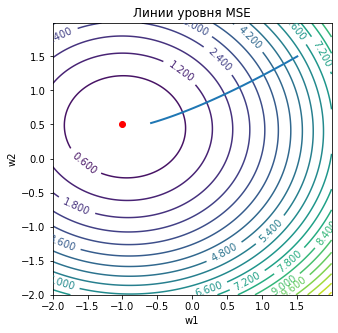

In [6]:
plot_gd(x_scale=1.0, lr=0.1, steps=25)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeA/t/wD7QH7QPwI0D4c2P7NvhSz1fxB43%2BIp0Ca3uvDLauyWy6Jq2os8VuNS08b9%2Bnxgu1wFVGkO1jtFVGLnJRW7FKSjFt9D36ivhxPin/wXl1lg3hv4I/CG2iY/JJ4o8MvaHHqVtvE10w%2BmM10Ohwf8F7tVxLq/iL9k3SUPVJPDHiS4kX8E1EKf%2B%2Bq6JYSpFayj/wCBR/Rs544qnJ6KX/gMv1SPsKivm7QvBv8AwV7uNv8Awk37SH7N1nn7wsfgnr9zj6b/ABJFmuguNA/b30uS0sNZ/a5%2BB0N1dt5dvHJ8DNUjNxIBkiNW8VZJ74GSBXPKDTte/pqbxlzK9rep7jRXgNtc/tm3vjK5%2BHNn%2B2x8AZfENnbLcXegxfBrUWvYIWxtkeAeKt6qcjDEYORWx/wg/wDwUL/6Og%2BDP/hh9W/%2Baik4yjuhpp7Hs1FeM/8ACD/8FC/%2BjoPgz/4YfVv/AJqKP%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRSGezVg/E6T4mxfD/AFZ/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/AIQf/goX/wBHQfBn/wAMPq3/AM1FH/CD/wDBQv8A6Og%2BDP8A4YfVv/mooA4D4W/sAeLvg/a/sweH9F8dadq1t8E7jWbnxhql6klvPrF1qGkXlvNcW8Kq6qXvLtpSjuNiMQGcjB8i/YN/4JLfHX9mq6%2BA/wAQPjF4/wDCWt%2BMfh7eXlr4uvNJubowRaJDoN5pWk6dpxlgVpEje5ku5fNEX76%2Bu2XI2LX05/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHzn%2Byd/wSI8Xfs16P8As03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf8AgkT8evgB4T%2BDGsfFH4g%2BENa8b%2BDfAGp%2BGvG%2BqafdXX2drZNCttG0azsN9uGNtBFbGWTeIyZ7q5lVCZio%2Bpv%2BEH/4KF/9HQfBn/ww%2Brf/ADUVh6/4H/4KqRO7%2BFv2oP2fZ1J/dx6h8B9ciI9iyeKHz9cD6U0ruwm7I8T/AGBv%2BCWHxq/Zf174FfEj4t%2BO/C2ueLfBHgrVNE%2BIWpaXcXJjlT%2BztK03SLTTxJApa2t7XTfn8zyi0000wTdO4E3/AAVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W7TW9G/4Lq2QZvD/xK/ZO1EDot14F8TWjN%2BWqSjP41yt743/4L/6NcFL34X/s%2BanEP%2BWnh/SL52b6Ld63bj82FdEcLOe0o/8AgSX52MJYmEN4y/8AAW/yucr8WPhD%2B0r8W/21/wBqz4H/ALOdl8PYNK8cfBzwb4X8QX3i66ureTQre4ttdgF5aw21vKt8UimmH2SRrZSwQ%2Bco3Keq8d/8E4P2go9K%2BJX7OHww8S%2BDpvhX8YPEeg6r4k8SeINTu18RaCtlp2k6bdQW1vHbPDfGaDR4GimkuLc28k7kpMqItQ/8NN/8FXfD/wC7%2BI3wgj09x959C/Z8fWYl/G18alj%2BCGj/AIbz%2BN%2Bkfu/iR%2B054S8FSj70fjD9j7xdZBfrIfEBjH4tVfUcW9oX9Gn%2BTf5E/XsIt5W9U1%2BaX5mR4f8A%2BCZn7S2nfttXHxyebwvbaCPj9ceP7TXX%2BLGv37Cwls/sz2I8LzWa6TDduhkT%2B0EmM8ayEqSRg6Xwd/4JK%2BKfhe/wY8Yt4/vp/EvgT44634v8V29x8UfEV3ocmmXi%2BIBHHYaXcSNYw3Q/tOz3FLeHG25xIdx83sPBH7VPxE%2BI5SPwZ/wVA/ZevJpPuWv/AAq69jnP/bKTxWr/AKV6bY%2BFv2/NUtEv9M/at%2BCdxBIMxzQfAvVXRh6gjxTg1hUpVaTtOLXqmvzSNqdWlVV4ST9Gn%2BTZ4n8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4

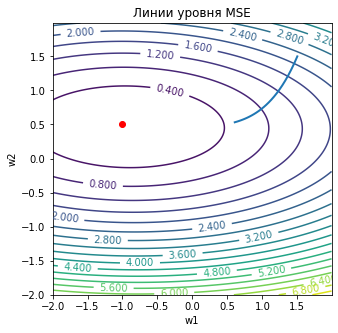

In [7]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeSftU/Eb40%2BD9Y%2BF/gT4F6/4X0nVPH3xCl0O81XxZ4audWt7W1i0HWNTZkt7e9s2aRpNOiQMZdoWRztY4wAet0V4z/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHs1FeM/8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHs1FeM/wDCD/8ABQv/AKOg%2BDP/AIYfVv8A5qKP%2BEH/AOChf/R0HwZ/8MPq3/zUUAezUV4z/wAIP/wUL/6Og%2BDP/hh9W/8Amoo/4Qf/AIKF/wDR0HwZ/wDDD6t/81FAHs1YPxOk%2BJsXw/1Z/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQv/AKOg%2BDP/AIYfVv8A5qKAOA%2BFv7AHi74P2v7MHh/RfHWnatbfBO41m58YapepJbz6xdahpF5bzXFvCquql7y7aUo7jYjEBnIwfIv2Df8Agkt8df2arr4D/ED4xeP/AAlrfjH4e3l5a%2BLrzSbm6MEWiQ6DeaVpOnacZYFaRI3uZLuXzRF%2B%2BvrtlyNi19Of8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHzn%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKj6m/4Qf8A4KF/9HQfBn/ww%2Brf/NRR/wAIP/wUL/6Og%2BDP/hh9W/8AmooA%2Bd/2Bv8Aglh8av2X9e%2BBXxI%2BLfjvwtrni3wR4K1TRPiFqWl3FyY5U/s7StN0i008SQKWtre1035/M8otNNNME3TuBN/wVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W%2Bgv%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRR/wg/wDwUL/6Og%2BDP/hh9W/%2BaigD5d%2BLHwh/aV%2BLf7a/7VnwP/Zzsvh7BpXjj4OeDfC/iC%2B8XXV1byaFb3FtrsAvLWG2t5VvikU0w%2BySNbKWCHzlG5T1Xjv/AIJwftBR6V8Sv2cPhh4l8HTfCv4weI9B1XxJ4k8Qandr4i0FbLTtJ026gtreO2eG%2BM0GjwNFNJcW5t5J3JSZURa94/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaigD5q8P8A/BMz9pbTv22rj45PN4XttBHx%2BuPH9prr/FjX79hYS2f2Z7EeF5rNdJhu3QyJ/aCTGeNZCVJIwdL4O/8ABJXxT8L3%2BDHjFvH99P4l8CfHHW/F/iu3uPij4iu9Dk0y8XxAI47DS7iRrGG6H9p2e4pbw423OJDuPm/Qf/CD/wDBQv8A6Og%2BDP8A4YfVv/moo/4Qf/goX/0dB8Gf/DD6t/8ANRQB4b8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4YfIUiT0L9qj9gvUv2pf2g28c6140/sTw%2B3wjuvDtrqej3JXWdJ1sa5pmq2GpWoeFoc282nrKrMSfMRBsZSSM0eMP%2BCj118VI/hbcfG/4XaDPex3baJfa5%2BzxfvbaqLZkEzQtB4zaRABIjATRxlgSRnBApR%2BK/%2BCo118Yrz4K2vx8%2BCMWoWukrqMWoX/7PeuRWV3CXCHypB4qYsysQCCo9s1t7Cp%2BF/l3MHiaS772269iDwJ%2BwT8R/2cofiNofwQ8D/Dfxb4Z1/wANeDfD/h/wh8RNTuUt73TtIsJbS5S%2Bkjspwkkm5HVxFcBzuLoCa8i1f/gkl8Ybn4Uaroem/A74FR6Xqfx10TxvB%2Bz5/bt3/wAIRp9hZae1tc2sc76Q4Ml1K3nyBdOjh3AfIW3O3

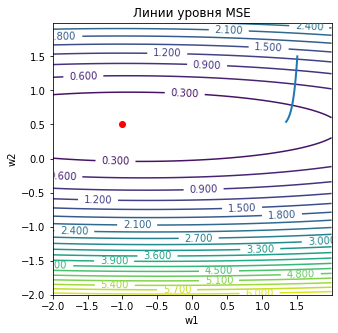

In [8]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeSftU/Eb40%2BD9Y%2BF/gT4F6/4X0nVPH3xCl0O81XxZ4audWt7W1i0HWNTZkt7e9s2aRpNOiQMZdoWRztY4wAet0V4z/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHs1FeM/8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHs1FeM/wDCD/8ABQv/AKOg%2BDP/AIYfVv8A5qKP%2BEH/AOChf/R0HwZ/8MPq3/zUUAezUV4z/wAIP/wUL/6Og%2BDP/hh9W/8Amoo/4Qf/AIKF/wDR0HwZ/wDDD6t/81FAHs1YPxOk%2BJsXw/1Z/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQv/AKOg%2BDP/AIYfVv8A5qKAOA%2BFv7AHi74P2v7MHh/RfHWnatbfBO41m58YapepJbz6xdahpF5bzXFvCquql7y7aUo7jYjEBnIwfIv2Df8Agkt8df2arr4D/ED4xeP/AAlrfjH4e3l5a%2BLrzSbm6MEWiQ6DeaVpOnacZYFaRI3uZLuXzRF%2B%2BvrtlyNi19Of8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHzn%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKj6m/4Qf8A4KF/9HQfBn/ww%2Brf/NRR/wAIP/wUL/6Og%2BDP/hh9W/8AmooA%2Bd/2Bv8Aglh8av2X9e%2BBXxI%2BLfjvwtrni3wR4K1TRPiFqWl3FyY5U/s7StN0i008SQKWtre1035/M8otNNNME3TuBN/wVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W%2Bgv%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRR/wg/wDwUL/6Og%2BDP/hh9W/%2BaigD5d%2BLHwh/aV%2BLf7a/7VnwP/Zzsvh7BpXjj4OeDfC/iC%2B8XXV1byaFb3FtrsAvLWG2t5VvikU0w%2BySNbKWCHzlG5T1Xjv/AIJwftBR6V8Sv2cPhh4l8HTfCv4weI9B1XxJ4k8Qandr4i0FbLTtJ026gtreO2eG%2BM0GjwNFNJcW5t5J3JSZURa94/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaigD5q8P8A/BMz9pbTv22rj45PN4XttBHx%2BuPH9prr/FjX79hYS2f2Z7EeF5rNdJhu3QyJ/aCTGeNZCVJIwdL4O/8ABJXxT8L3%2BDHjFvH99P4l8CfHHW/F/iu3uPij4iu9Dk0y8XxAI47DS7iRrGG6H9p2e4pbw423OJDuPm/Qf/CD/wDBQv8A6Og%2BDP8A4YfVv/moo/4Qf/goX/0dB8Gf/DD6t/8ANRQB4b8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4YfIUiT0L9qj9gvUv2pf2g28c6140/sTw%2B3wjuvDtrqej3JXWdJ1sa5pmq2GpWoeFoc282nrKrMSfMRBsZSSM0eMP%2BCj118VI/hbcfG/4XaDPex3baJfa5%2BzxfvbaqLZkEzQtB4zaRABIjATRxlgSRnBApR%2BK/%2BCo118Yrz4K2vx8%2BCMWoWukrqMWoX/7PeuRWV3CXCHypB4qYsysQCCo9s1t7Cp%2BF/l3MHiaS772269iDwJ%2BwT8R/2cofiNofwQ8D/Dfxb4Z1/wANeDfD/h/wh8RNTuUt73TtIsJbS5S%2Bkjspwkkm5HVxFcBzuLoCa8i1f/gkl8Ybn4Uaroem/A74FR6Xqfx10TxvB%2Bz5/bt3/wAIRp9hZae1tc2sc76Q4Ml1K3nyBdOjh3AfIW3O3

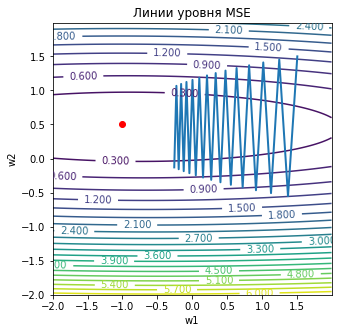

In [9]:
# попробуем шаг побольше?
# w0 меняется быстрее, но w1 меняется слишком быстро, приводит к осциллированию
plot_gd(x_scale=0.2, lr=2.0, steps=25)

# Adam

Адам работает как зайка, ему не важен масштаб признаков, у него адаптивный learning rate и инерция!

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeJ/tofEv9pXwVL8LvAv7LGp%2BBtP8Q%2BP/AIlHQr3U/iBod5qNlZ2Eeh6vqc0iQWl1au82dORFzKFw7Z6hlaV3YD2yivGf%2BEH/AOChff8Aah%2BDP/hh9W/%2BaiqLad%2B3KviIeEG/bC%2BBY1ZrX7Suln4Jan9oMOdvm%2BX/AMJVu2Z43YxnvQk3sB7pRXh2uaL%2B3d4Y0mfX/Ev7XXwO06xtU33N7ffBDVIYYl/vM7%2BKQFHuTXg%2Bvf8ABQH4uLq8/hf4TftffDb4pazA%2B2TSvhV%2BzF4g10g%2B9xB4m%2BzJ9WlHr05rajhsRiL%2Bzg3bstF6vZfNoTaW5900V8K6P8WP%2BC9Xj%2B%2BRvAfwd%2BDOh6XKcxaj8S/CV3pku3sWtrDxDfSL9GINet%2BAfB//AAV2vAs3xR/aI/Zw044O620D4M6/e846CSbxFB377PwFOrhqlFe84%2Bikm/wv%2BYJpn0fRXjP/AAg//BQv/o6D4M/%2BGH1b/wCaij/hB/8AgoX/ANHQfBn/AMMPq3/zUVzjPZqwfidJ8TYvh/qz/Bmy0K48U/Y2GhR%2BJ7qaHT/tB4Vp2gR5Ng5YhFy2NuVzuHm//CD/APBQv/o6D4M/%2BGH1b/5qKP8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUAcB8Lf2APF3wftf2YPD%2Bi%2BOtO1a2%2BCdxrNz4w1S9SS3n1i61DSLy3muLeFVdVL3l20pR3GxGIDORg%2BRfsG/8ABJb46/s1XXwH%2BIHxi8f%2BEtb8Y/D28vLXxdeaTc3Rgi0SHQbzStJ07TjLArSJG9zJdy%2BaIv319dsuRsWvpXUvAv8AwUcaxkGkftSfBJbnb%2B5Nz8BNYZM%2B4XxSD%2BXT36V5R48j/wCC9nhffd%2BCPEH7KviuBPuwDwh4h025f6LJqskf5yCtaVJ1XZNL1aX5ibscj%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKjYP7YH/BT/wAAfu/2k/h/YeDkTm41fQ/2c9Q8TaZCnd2m0zxZJKq%2B7Qj3weK9B%2BCv7Sfxi/aIm%2BwfBr/gox%2Bztrd%2BCRJo8fwW1WHUIyOoe0m8UJOmOfvIOh9K1qYHF04c7g3HurSX3xbX32BSTOE/YG/4JYfGr9l/XvgV8SPi3478La54t8EeCtU0T4halpdxcmOVP7O0rTdItNPEkClra3tdN%2BfzPKLTTTTBN07gTf8ABWP4a2vxu%2BPHwb%2BBXwu%2BImn2fjb4hT6h4O%2BIHh%2BGfde3Pw2vkW61y4ZEO6JAdLht4rhwEEt20anfLtb6C/4Qf/goX/0dB8Gf/DD6t/8ANRSr4H/4KEhgX/af%2BDRGeQPgRqwOP/CorlGfLnxY%2BEP7Svxb/bX/AGrPgf8As52Xw9g0rxx8HPBvhfxBfeLrq6t5NCt7i212AXlrDbW8q3xSKaYfZJGtlLBD5yjcp6rx3/wTg/aCj0r4lfs4fDDxL4Om%2BFfxg8R6DqviTxJ4g1O7XxFoK2WnaTpt1BbW8ds8N8ZoNHgaKaS4tzbyTuSkyoi16bdT/wDBTnw%2BNUu/GvxY%2BCtrZ2sN3dWF1ovwj1i/EkEKBwJhJr9v5MrgnaAXXKsNw4Lea3f7V/7dFta%2BGTD8Y/g3fXeteD7XW9WstH%2BEeqXR02W82LYWSMfESLcy3D%2Bftz5QWO1mkbhQG6o4OtUvyWfo/K/9bdDN1YLfQ5/w/wD8EzP2ltO/bauPjk83he20EfH648f2muv8WNfv2FhLZ/ZnsR4Xms10mG7dDIn9oJMZ41kJUkjB0vg7/wAElfFPwvf4MeMW8f30/iXwJ8cdb8X%2BK7e4%2BKPiK70OTTLxfEAjjsNLuJGsYbof2nZ7ilvDjbc4kO4%2Bb2/w8%2BLf7d2saLrl18X/ANpT4E%2BBb3w74iTRtTi1P4T38lqbmS3huY0iuj4oRJGMc6ZQAMrhlwcBj13xL

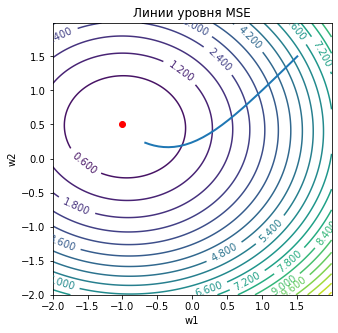

In [10]:
plot_gd(x_scale=1.0, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeA/t/wD7QH7QPwI0D4c2P7NvhSz1fxB43%2BIp0Ca3uvDLauyWy6Jq2os8VuNS08b9%2Bnxgu1wFVGkO1jtFVGLnJRW7FKSjFt9D36ivhxPin/wXl1lg3hv4I/CG2iY/JJ4o8MvaHHqVtvE10w%2BmM10Ohwf8F7tVxLq/iL9k3SUPVJPDHiS4kX8E1EKf%2B%2Bq6JYSpFayj/wCBR/Rs544qnJ6KX/gMv1SPsKivm7QvBv8AwV7uNv8Awk37SH7N1nn7wsfgnr9zj6b/ABJFmuguNA/b30uS0sNZ/a5%2BB0N1dt5dvHJ8DNUjNxIBkiNW8VZJ74GSBXPKDTte/pqbxlzK9rep7jRXgNtc/tm3vjK5%2BHNn%2B2x8AZfENnbLcXegxfBrUWvYIWxtkeAeKt6qcjDEYORWx/wg/wDwUL/6Og%2BDP/hh9W/%2Baik4yjuhpp7Hs1FeM/8ACD/8FC/%2BjoPgz/4YfVv/AJqKP%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRSGezVg/E6T4mxfD/AFZ/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/AIQf/goX/wBHQfBn/wAMPq3/AM1FH/CD/wDBQv8A6Og%2BDP8A4YfVv/mooA4D4W/sAeLvg/a/sweH9F8dadq1t8E7jWbnxhql6klvPrF1qGkXlvNcW8Kq6qXvLtpSjuNiMQGcjB8i/YN/4JLfHX9mq6%2BA/wAQPjF4/wDCWt%2BMfh7eXlr4uvNJubowRaJDoN5pWk6dpxlgVpEje5ku5fNEX76%2Bu2XI2LX05/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHzn%2Byd/wSI8Xfs16P8As03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf8AgkT8evgB4T%2BDGsfFH4g%2BENa8b%2BDfAGp%2BGvG%2BqafdXX2drZNCttG0azsN9uGNtBFbGWTeIyZ7q5lVCZio%2Bpv%2BEH/4KF/9HQfBn/ww%2Brf/ADUVh6/4H/4KqRO7%2BFv2oP2fZ1J/dx6h8B9ciI9iyeKHz9cD6U0ruwm7I8T/AGBv%2BCWHxq/Zf174FfEj4t%2BO/C2ueLfBHgrVNE%2BIWpaXcXJjlT%2BztK03SLTTxJApa2t7XTfn8zyi0000wTdO4E3/AAVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W7TW9G/4Lq2QZvD/xK/ZO1EDot14F8TWjN%2BWqSjP41yt743/4L/6NcFL34X/s%2BanEP%2BWnh/SL52b6Ld63bj82FdEcLOe0o/8AgSX52MJYmEN4y/8AAW/yucr8WPhD%2B0r8W/21/wBqz4H/ALOdl8PYNK8cfBzwb4X8QX3i66ureTQre4ttdgF5aw21vKt8UimmH2SRrZSwQ%2Bco3Keq8d/8E4P2go9K%2BJX7OHww8S%2BDpvhX8YPEeg6r4k8SeINTu18RaCtlp2k6bdQW1vHbPDfGaDR4GimkuLc28k7kpMqItQ/8NN/8FXfD/wC7%2BI3wgj09x959C/Z8fWYl/G18alj%2BCGj/AIbz%2BN%2Bkfu/iR%2B054S8FSj70fjD9j7xdZBfrIfEBjH4tVfUcW9oX9Gn%2BTf5E/XsIt5W9U1%2BaX5mR4f8A%2BCZn7S2nfttXHxyebwvbaCPj9ceP7TXX%2BLGv37Cwls/sz2I8LzWa6TDduhkT%2B0EmM8ayEqSRg6Xwd/4JK%2BKfhe/wY8Yt4/vp/EvgT44634v8V29x8UfEV3ocmmXi%2BIBHHYaXcSNYw3Q/tOz3FLeHG25xIdx83sPBH7VPxE%2BI5SPwZ/wVA/ZevJpPuWv/AAq69jnP/bKTxWr/AKV6bY%2BFv2/NUtEv9M/at%2BCdxBIMxzQfAvVXRh6gjxTg1hUpVaTtOLXqmvzSNqdWlVV4ST9Gn%2BTZ4n8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4

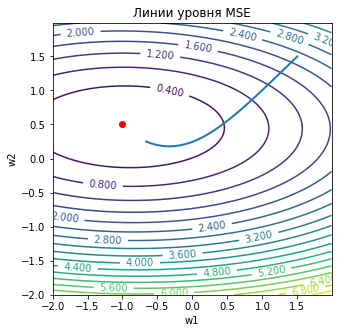

In [11]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeSftU/Eb40%2BD9Y%2BF/gT4F6/4X0nVPH3xCl0O81XxZ4audWt7W1i0HWNTZkt7e9s2aRpNOiQMZdoWRztY4wAet0V4z/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHs1FeM/8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHs1FeM/wDCD/8ABQv/AKOg%2BDP/AIYfVv8A5qKP%2BEH/AOChf/R0HwZ/8MPq3/zUUAezUV4z/wAIP/wUL/6Og%2BDP/hh9W/8Amoo/4Qf/AIKF/wDR0HwZ/wDDD6t/81FAHs1YPxOk%2BJsXw/1Z/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQv/AKOg%2BDP/AIYfVv8A5qKAOA%2BFv7AHi74P2v7MHh/RfHWnatbfBO41m58YapepJbz6xdahpF5bzXFvCquql7y7aUo7jYjEBnIwfIv2Df8Agkt8df2arr4D/ED4xeP/AAlrfjH4e3l5a%2BLrzSbm6MEWiQ6DeaVpOnacZYFaRI3uZLuXzRF%2B%2BvrtlyNi19Of8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHzn%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKj6m/4Qf8A4KF/9HQfBn/ww%2Brf/NRR/wAIP/wUL/6Og%2BDP/hh9W/8AmooA%2Bd/2Bv8Aglh8av2X9e%2BBXxI%2BLfjvwtrni3wR4K1TRPiFqWl3FyY5U/s7StN0i008SQKWtre1035/M8otNNNME3TuBN/wVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W%2Bgv%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRR/wg/wDwUL/6Og%2BDP/hh9W/%2BaigD5d%2BLHwh/aV%2BLf7a/7VnwP/Zzsvh7BpXjj4OeDfC/iC%2B8XXV1byaFb3FtrsAvLWG2t5VvikU0w%2BySNbKWCHzlG5T1Xjv/AIJwftBR6V8Sv2cPhh4l8HTfCv4weI9B1XxJ4k8Qandr4i0FbLTtJ026gtreO2eG%2BM0GjwNFNJcW5t5J3JSZURa94/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaigD5q8P8A/BMz9pbTv22rj45PN4XttBHx%2BuPH9prr/FjX79hYS2f2Z7EeF5rNdJhu3QyJ/aCTGeNZCVJIwdL4O/8ABJXxT8L3%2BDHjFvH99P4l8CfHHW/F/iu3uPij4iu9Dk0y8XxAI47DS7iRrGG6H9p2e4pbw423OJDuPm/Qf/CD/wDBQv8A6Og%2BDP8A4YfVv/moo/4Qf/goX/0dB8Gf/DD6t/8ANRQB4b8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4YfIUiT0L9qj9gvUv2pf2g28c6140/sTw%2B3wjuvDtrqej3JXWdJ1sa5pmq2GpWoeFoc282nrKrMSfMRBsZSSM0eMP%2BCj118VI/hbcfG/4XaDPex3baJfa5%2BzxfvbaqLZkEzQtB4zaRABIjATRxlgSRnBApR%2BK/%2BCo118Yrz4K2vx8%2BCMWoWukrqMWoX/7PeuRWV3CXCHypB4qYsysQCCo9s1t7Cp%2BF/l3MHiaS772269iDwJ%2BwT8R/2cofiNofwQ8D/Dfxb4Z1/wANeDfD/h/wh8RNTuUt73TtIsJbS5S%2Bkjspwkkm5HVxFcBzuLoCa8i1f/gkl8Ybn4Uaroem/A74FR6Xqfx10TxvB%2Bz5/bt3/wAIRp9hZae1tc2sc76Q4Ml1K3nyBdOjh3AfIW3O3

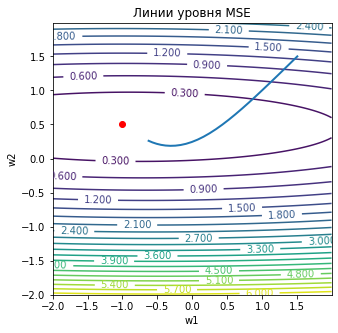

In [12]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivkH9n7/gpF8cfi/8S/hlpvi39l7wnofgv4r%2BKvFOieGtf034pXN/qcD6KNQLS3Ng%2BjQRIs39nvgJdyFRIud2CK9b8H/t/fsh%2BPvFfwv8D%2BEfjHBeav8AGbw9da58N9PXSb1ZdV0%2B3h8%2BW4YNCPsqiPJUXHlFyjqgZkYAA9jorzLwh%2B2L%2Bzj498O/DfxX4T%2BIv2vT/i7ocusfDy4/si8j/tayjsxevLteENBi3YPtmEbHO0Dd8tY3h7/goR%2Bx54r8QeAfCnh74zQXWpfE/wCHTeO/BFimkXolv/DwgWf7c6mEG2Vo3yqT%2BXI5WRVQtG4UA9moryTwT%2B3V%2Byl8RfiJ4E%2BE3gv4uQX3iP4l/D5PHHgvSU0u7WS%2B0B1Rkvn3wgWysJBtScxyMVcBSY3C9Xqvx8%2BEWhePNf8AhnrnjSGy1nwv4Sg8T65bXlvLElvpMslzGt2JWQRyKHs5w4RmaPapcKJIywB2FFfPOvf8FVP2FPDN5DY658YdRgZ/C2leJbyT/hBdbaPStG1KMyWmoX8i2ZTTrZlU7pboxLERtlMbcV1Pjz9u39lb4afFpfgl4y%2BJ722ui60%2B1vXh0C/uNP0y4v2VbGC%2B1CGBrOwluC6eVHczRvL5ibA29cgHrtFeLaR/wUG/ZS1r43S/s92njfW4vEUXiqbwyJ73wFrVtpMutRQG4fTo9Vms1sJbnylLiFJ2dgDtBPFdBon7Xf7PHiPw34O8XaN8QvO07x/4xu/CvhK4/sm7X7fq9sL4z221og0W3%2Bzb395IEjPk8Md6bgD0mivFfh//AMFCf2Ufil8YbD4G%2BBfG2uXut6te6nZ6LeN4A1uHSNUn04uL2O01WWzWwujCY5A3lTvyhAyRisP46/t8WvwK/bn%2BFf7HmtfC17nTPiVpN7c3HjddZEaaLcRyLDawyW3knzFuJ3jgWQSrtlmiXa2/KgH0NRXxFb/8Fm9Fv7f4u39j8CI47HwD8TNF8F%2BDtW1PxnHa2XiWbUr%2BbT47%2B5ne326ZZLc28v73/SDJEEdFYyJGfR/il%2B2B%2B1P8I/hX4W1rxN%2By/wCAp/GPjT4naf4S8OaRp3xhuZtEuIruB5Uv21IaKJ1UGN0Mf2Ik7QQxBBoA%2BlqK5P4Oax8ctb8KyXn7QPw68J%2BGNcF66w6d4O8Z3Ou2jWwVCshuLnTrB1kLFwYxCQAqkO24qvWUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFeSftU/Eb40%2BD9Y%2BF/gT4F6/4X0nVPH3xCl0O81XxZ4audWt7W1i0HWNTZkt7e9s2aRpNOiQMZdoWRztY4wAet0V4z/wg/wDwUL/6Og%2BDP/hh9W/%2Baij/AIQf/goX/wBHQfBn/wAMPq3/AM1FAHs1FeM/8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHs1FeM/wDCD/8ABQv/AKOg%2BDP/AIYfVv8A5qKP%2BEH/AOChf/R0HwZ/8MPq3/zUUAezUV4z/wAIP/wUL/6Og%2BDP/hh9W/8Amoo/4Qf/AIKF/wDR0HwZ/wDDD6t/81FAHs1YPxOk%2BJsXw/1Z/gzZaFceKfsbDQo/E91NDp/2g8K07QI8mwcsQi5bG3K53Dzf/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQv/AKOg%2BDP/AIYfVv8A5qKAOA%2BFv7AHi74P2v7MHh/RfHWnatbfBO41m58YapepJbz6xdahpF5bzXFvCquql7y7aUo7jYjEBnIwfIv2Df8Agkt8df2arr4D/ED4xeP/AAlrfjH4e3l5a%2BLrzSbm6MEWiQ6DeaVpOnacZYFaRI3uZLuXzRF%2B%2BvrtlyNi19Of8IP/AMFC/wDo6D4M/wDhh9W/%2Baij/hB/%2BChf/R0HwZ/8MPq3/wA1FAHzn%2Byd/wAEiPF37Nej/s03w%2BIN5fa38Kvh/faJ8QI9R%2BKXiPVtMmu59EWxDaTZX8j21rCJwTiKG12xYAXAEYxf2Nf%2BCRPx6%2BAHhP4Max8UfiD4Q1rxv4N8Aan4a8b6pp91dfZ2tk0K20bRrOw324Y20EVsZZN4jJnurmVUJmKj6m/4Qf8A4KF/9HQfBn/ww%2Brf/NRR/wAIP/wUL/6Og%2BDP/hh9W/8AmooA%2Bd/2Bv8Aglh8av2X9e%2BBXxI%2BLfjvwtrni3wR4K1TRPiFqWl3FyY5U/s7StN0i008SQKWtre1035/M8otNNNME3TuBN/wVj%2BGtr8bvjx8G/gV8LviJp9n42%2BIU%2BoeDviB4fhn3Xtz8Nr5FutcuGRDuiQHS4beK4cBBLdtGp3y7W%2Bgv%2BEH/wCChf8A0dB8Gf8Aww%2Brf/NRR/wg/wDwUL/6Og%2BDP/hh9W/%2BaigD5d%2BLHwh/aV%2BLf7a/7VnwP/Zzsvh7BpXjj4OeDfC/iC%2B8XXV1byaFb3FtrsAvLWG2t5VvikU0w%2BySNbKWCHzlG5T1Xjv/AIJwftBR6V8Sv2cPhh4l8HTfCv4weI9B1XxJ4k8Qandr4i0FbLTtJ026gtreO2eG%2BM0GjwNFNJcW5t5J3JSZURa94/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaigD5q8P8A/BMz9pbTv22rj45PN4XttBHx%2BuPH9prr/FjX79hYS2f2Z7EeF5rNdJhu3QyJ/aCTGeNZCVJIwdL4O/8ABJXxT8L3%2BDHjFvH99P4l8CfHHW/F/iu3uPij4iu9Dk0y8XxAI47DS7iRrGG6H9p2e4pbw423OJDuPm/Qf/CD/wDBQv8A6Og%2BDP8A4YfVv/moo/4Qf/goX/0dB8Gf/DD6t/8ANRQB4b8Av%2BCXnjr4S/tN%2BB/2mrzxdbQTaf418Za1r/g7TvGmrz6Dodpq0Dx2lno2nzYtYyGPnXE4igeWae4YfIUiT0L9qj9gvUv2pf2g28c6140/sTw%2B3wjuvDtrqej3JXWdJ1sa5pmq2GpWoeFoc282nrKrMSfMRBsZSSM0eMP%2BCj118VI/hbcfG/4XaDPex3baJfa5%2BzxfvbaqLZkEzQtB4zaRABIjATRxlgSRnBApR%2BK/%2BCo118Yrz4K2vx8%2BCMWoWukrqMWoX/7PeuRWV3CXCHypB4qYsysQCCo9s1t7Cp%2BF/l3MHiaS772269iDwJ%2BwT8R/2cofiNofwQ8D/Dfxb4Z1/wANeDfD/h/wh8RNTuUt73TtIsJbS5S%2Bkjspwkkm5HVxFcBzuLoCa8i1f/gkl8Ybn4Uaroem/A74FR6Xqfx10TxvB%2Bz5/bt3/wAIRp9hZae1tc2sc76Q4Ml1K3nyBdOjh3AfIW3O3

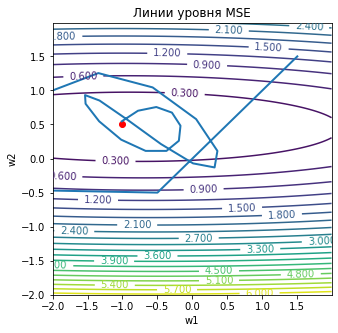

In [13]:
# сломает ли его шаг побольше?
# слишком большие шаги, закручиваемся вокруг решения из-за момента
plot_gd(x_scale=0.2, lr=2.0, steps=25, optimizer='adam')

Если хочется почитать подробнее: http://cnl.salk.edu/~schraudo/teach/NNcourse/precond.html